<a href="https://colab.research.google.com/github/dscho15/DeepLearning/blob/main/Lecture3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MLP (one hidden layer) for classification on Cifar10

In [37]:
import copy

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T

In [47]:
class Cifar10(torchvision.datasets.CIFAR10):
  def __init__(self, train: bool):
    super().__init__(root='~/data', train=train, download=True)
    self.data = self.data.astype(np.float32) / 255 - 0.5

  def __getitem__(self, idx):
    return self.data[idx], self.targets[idx]

# Recieve the training data and split it into: {train, validation}
data_train = Cifar10(train=True)
data_train, data_valid = torch.utils.data.random_split(data_train, (45000, 5000))
data_test = Cifar10(train=False)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
kwargs = {'batch_size': 100, 'num_workers': 2}
loader_train = torch.utils.data.DataLoader(data_train, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(data_valid, **kwargs)
loader_test = torch.utils.data.DataLoader(data_test, **kwargs)

# Challenge
* Build a Multi Layer Perceptron, MLP, with one ReLU-activated hidden layer.
* Use the validation set to inform e.g. number of hidden neurons.
* When you're satisfied, then, use the test set to get an  
unbiased estimate of your models performance on the real data distribution.

In [71]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_hidden_neurons):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, n_hidden_neurons),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(n_hidden_neurons, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [72]:
all_losses, all_accuracies = {}, {}
best_accuracy = 0
best_model = None

In [74]:
device = torch.device('cuda')
n_hidden_neurons = 128
model = NeuralNetwork(n_hidden_neurons).to(device)
opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay = 10e-5)

train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in tqdm(range(50)):

  epoch_losses = []
  correct, total = 0, 0

  for x, y in loader_train:
    
    x, y = x.to(device), y.to(device)
    
    logits = model(x)
    log_probs = F.log_softmax(logits, dim=1)
    loss = F.nll_loss(log_probs, y)
    # or just: loss = F.cross_entropy(logits, y)

    opt.zero_grad()
    loss.backward()
    opt.step()

    epoch_losses.append(loss.item())
    total += len(x)
    correct += (torch.argmax(logits, dim=1) == y).sum().item()

  train_loss = np.mean(epoch_losses)
  train_accuracy = correct / total

  with torch.no_grad():

    valid_losses = []

    for x, y in loader_valid:

      x, y = x.to(device), y.to(device)
      logits = model(x)
      log_probs = F.log_softmax(logits, dim=1)
      loss = F.nll_loss(log_probs, y)

      total += len(x)
      valid_losses.append(loss.item())
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
  
  valid_loss = np.mean(valid_losses)
  valid_accuracy = correct/total

  if valid_accuracy > best_accuracy:
    best_accuracy = valid_accuracy
    best_model = copy.deepcopy(model), n_hidden_neurons, epoch

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  train_accuracies.append(train_accuracy)
  valid_accuracies.append(valid_accuracy)

all_losses[n_hidden_neurons] = train_losses, valid_losses
all_accuracies[n_hidden_neurons] = train_accuracies, valid_accuracies

  0%|          | 0/50 [00:00<?, ?it/s]

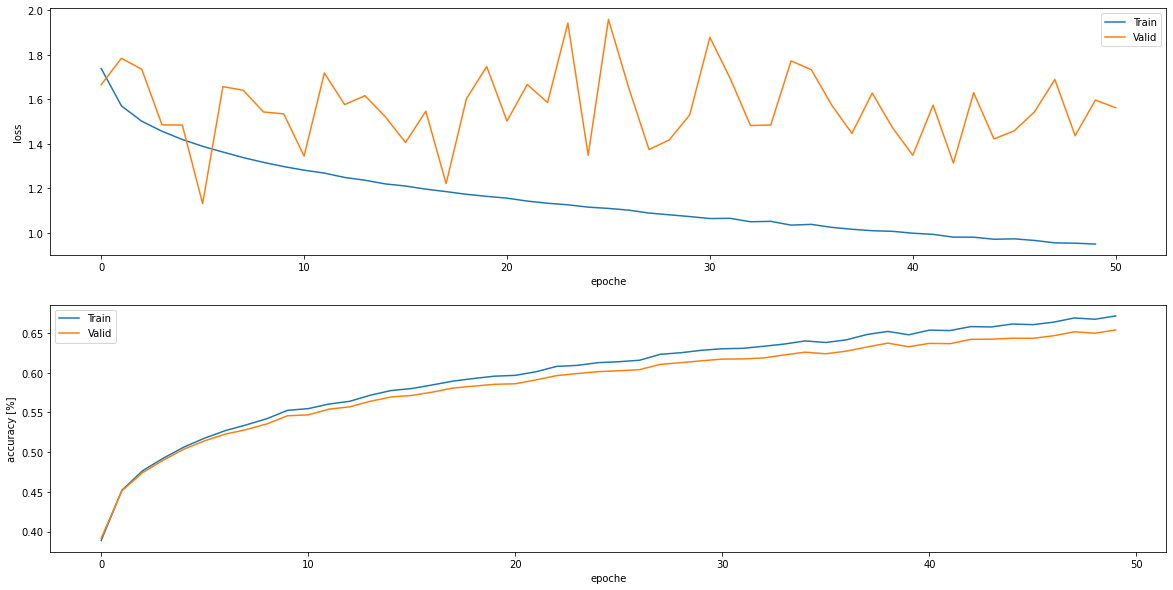

In [70]:
plt.figure(1, figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(train_losses)
plt.plot(valid_losses)
plt.xlabel("epoche")
plt.ylabel("loss")
plt.legend(["Train", "Valid"])

plt.subplot(2,1,2)
plt.plot(train_accuracies)
plt.plot(valid_accuracies)
plt.xlabel("epoche")
plt.ylabel("accuracy [%]")
plt.legend(["Train", "Valid"])

plt.show()

In [73]:
with torch.no_grad():

    for x, y in loader_test:

      x, y = x.to(device), y.to(device)
      logits = model(x)
      log_probs = F.log_softmax(logits, dim=1)
      loss = F.nll_loss(log_probs, y)

      total += len(x)
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
    
valid_accuracy = correct/total

print("The validation accuracy: %s"%(valid_accuracy))
  

The validation accuracy: 0.6269666666666667
